# EEG - Eye Tracking: A Wavelet Packets Approach

## Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from scipy.signal import medfilt
import pandas as pd

In [4]:
# Train
dir = "Data/dots/EP22/EP22_DOTS1_EEG"
EEG = pd.read_csv(dir + "/substream_0.csv")
labels_x = EEG['x'].values
labels_y = EEG['y'].values

# Test
dirtest = "Data/dots/EP22/EP22_DOTS2_EEG"
EEGtest = pd.read_csv(dirtest + "/substream_0.csv")
labels_xtest = EEGtest['x'].values
labels_ytest = EEGtest['y'].values

## Methods used for baseline drift removal

In [5]:
def getLRF_ts(EEGdata):
    # Gets data averaged over the left, right and front electrodes
    # left side
    Electr_128 = EEGdata['channel_127'].to_numpy()
    Electr_32 = EEGdata['channel_31'].to_numpy()
    Electr_38 = EEGdata['channel_37'].to_numpy()
    EEGleft = (Electr_128 + Electr_32 + Electr_38) / 3
    
    # Right side
    Electr_125 = EEGdata['channel_124'].to_numpy()
    Electr_1 = EEGdata['channel_0'].to_numpy()
    Electr_121 = EEGdata['channel_120'].to_numpy()
    EEGright = (Electr_125 + Electr_1 + Electr_121) / 3

    # front (node 17)
    EEGfront = EEGdata['channel_16'].to_numpy()
    return medfilt(EEGleft, 5), medfilt(EEGright, 5), medfilt(EEGfront, 5)


def remBaseline(EEGdata, wv_type='db4', toremove=[0,7,8]):
    # Removes baseline drift from EEG signal
    # Input: EEG signal
    # Output: EEG signal with baseline removed
   
    db = pywt.Wavelet(wv_type)
    levels = 8
    cA, cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8 = pywt.wavedec(EEGdata, db, level=levels)
    coeffs = [cA, cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8]

    for j in toremove:
        coeffs[j] = np.zeros(coeffs[j].shape)
    
    baseline_rem = pywt.waverec(coeffs, db)
    if EEGdata.shape != baseline_rem.shape:
        baseline_rem = baseline_rem[:-1]
    return np.array(baseline_rem), EEGdata - np.array(baseline_rem)

def getBaseRemoveData_ts(EEGdata, wv_type, toremove):
    EEGleft, EEGright, EEGfront = getLRF_ts(EEGdata)
    EEGleft_rem, EEGleft_base = remBaseline(EEGleft, wv_type, toremove)
    EEGright_rem, EEGright_base = remBaseline(EEGright, wv_type, toremove)
    EEGfront_rem, EEGfront_base = remBaseline(EEGfront, wv_type, toremove)
    return EEGleft_rem, EEGright_rem, EEGfront_rem, EEGleft_base, EEGright_base, EEGfront_base

def getData(EEG, blr=True, wv_type='db4', toremove=[0,7,8]):
    # returns baseline-removed EEG data and labels for whole time series
    # EEGdata is left, right and front averaged data concatenated for linear regression
    if blr:
        EEGleft_rem, EEGright_rem, EEGfront_rem, _, _, _ = getBaseRemoveData_ts(EEG, wv_type, toremove)
    else:
        EEGleft_rem, EEGright_rem, EEGfront_rem = getLRF_ts(EEG)
    EEGdata = np.transpose(np.vstack(((EEGleft_rem, EEGright_rem, EEGfront_rem))))
    return EEGdata

def getLinRegression(EEGs, labels, EEGtest=[], predict=False):
    # add assert here to make sure EEGs and labels have the same dimensions 
    fit = LinearRegression().fit(EEGs, labels.reshape((-1,1)))
    if predict:
        return fit.predict(EEGtest)
    else:
        return fit

def energy(cD):
        # Calculates the energy of the detail coefficients
        return np.sum(cD)

## Regression

### Comparison of Baseline Drift with no Baseline Drift

In [6]:
TR = [0,7,8]

# Get training and testing data for linear regression

EEGdata_ts = getData(EEG, toremove=TR)
EEGdata_norem = getData(EEG, blr=False)

EEGtest_ts = getData(EEGtest, toremove=TR)
EEGtest_norem = getData(EEGtest, blr=False)


# Perform linear regression

fitx = getLinRegression(EEGdata_ts, labels_x, predict=False)
fitx_norem = getLinRegression(EEGdata_norem, labels_x, predict=False)

fity = getLinRegression(EEGdata_ts, labels_y, predict=False)
fity_norem = getLinRegression(EEGdata_norem, labels_y, predict=False)


# Predict

predx = fitx.predict(EEGtest_ts)
predx_norem = fitx_norem.predict(EEGtest_norem)

predy = fity.predict(EEGtest_ts)
predy_norem = fity_norem.predict(EEGtest_norem)

Text(0.5, 1.0, 'EEGfront with and without BLR Patient22 Stream2')

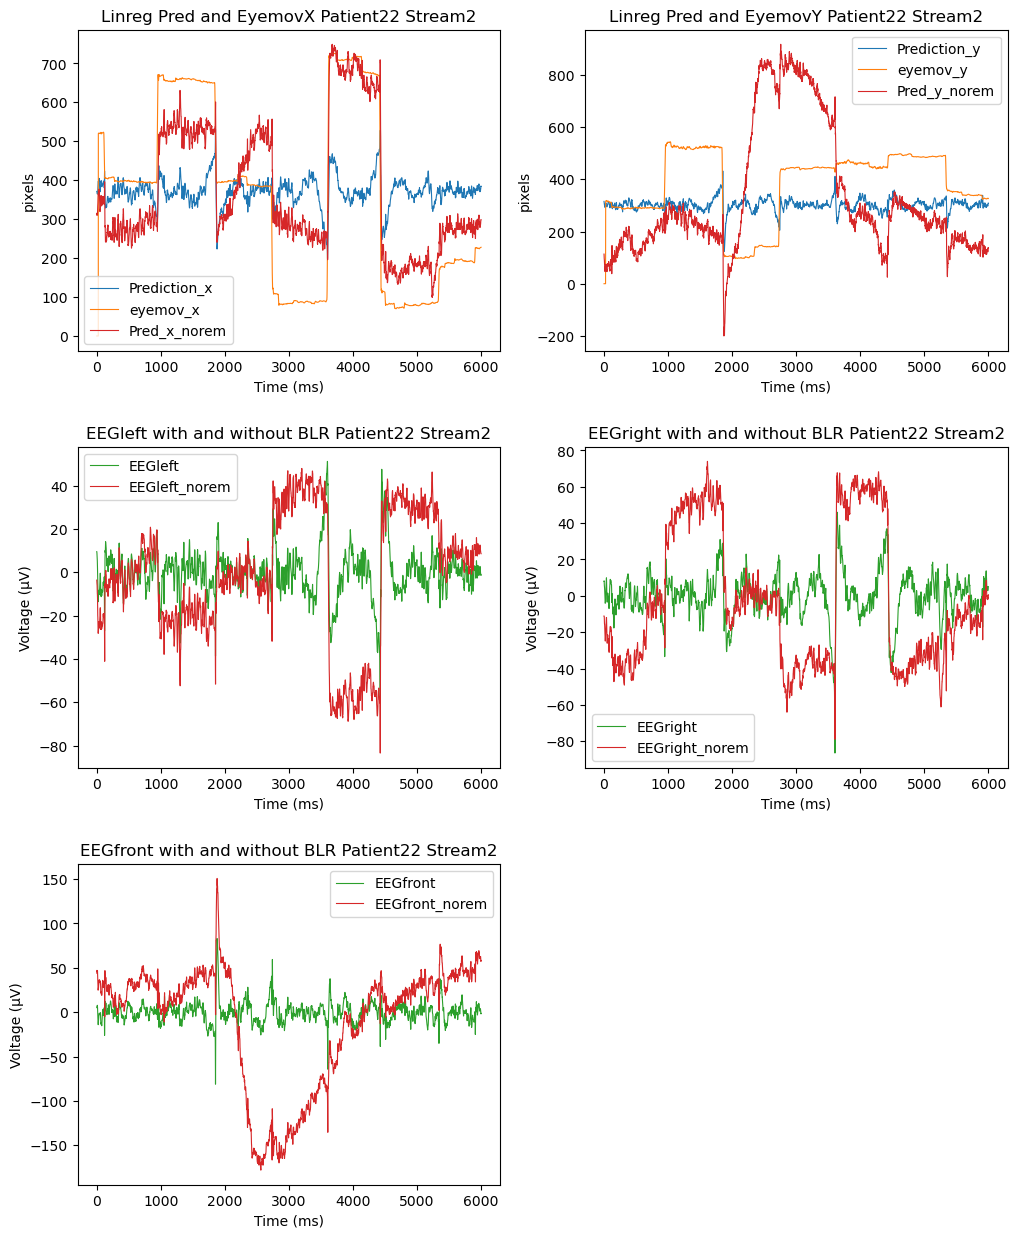

In [103]:
min_t = 0
max_t = 6000

plt.rcParams['figure.figsize'] = [12, 15]
plt.rc('lines', linewidth=.8)
plt.subplots_adjust(hspace=.3)

plt.subplot(3, 2, 1)
plt.plot(range(min_t,max_t), predx[min_t:max_t], label='Prediction_x')
plt.plot(range(min_t,max_t), labels_xtest[min_t:max_t], label='eyemov_x')
plt.plot(range(min_t,max_t), predx_norem[min_t:max_t], label='Pred_x_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovX Patient22 Stream2")

plt.subplot(3, 2, 2)
plt.plot(range(min_t,max_t), predy[min_t:max_t], label='Prediction_y')
plt.plot(range(min_t,max_t), labels_ytest[min_t:max_t], label='eyemov_y')
plt.plot(range(min_t,max_t), predy_norem[min_t:max_t], label='Pred_y_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovY Patient22 Stream2")

plt.subplot(3, 2, 3)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,0], label='EEGleft', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,0], label='EEGleft_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGleft with and without BLR Patient22 Stream2")

plt.subplot(3, 2, 4)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,1], label='EEGright', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,1], label='EEGright_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGright with and without BLR Patient22 Stream2")

plt.subplot(3, 2, 5)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,2], label='EEGfront', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,2], label='EEGfront_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGfront with and without BLR Patient22 Stream2")

### Calculate MSE

In [9]:
# Calculate MSE
MSE_y = mean_squared_error(labels_ytest, predy)
MSE_x = mean_squared_error(labels_xtest, predx)

print("MSE_y: ", MSE_y)
print("MSE_x: ", MSE_x)

MSE_y_norem = mean_squared_error(labels_ytest, predy_norem)
MSE_x_norem = mean_squared_error(labels_xtest, predx_norem)

print("MSE_y_norem: ", MSE_y_norem)
print("MSE_x_norem: ", MSE_x_norem)

MSE_y:  26624.641515336247
MSE_x:  42622.412126356314
MSE_y_norem:  31144.46285110553
MSE_x_norem:  16567.62271709905


## Saccade Detection

In [11]:
def getBaseRemoveData2(EEGdata, wv_type, toremove, leftthresh=60, rightthresh=60, frontthresh=100):
    EEGleft_rem, EEGright_rem, EEGfront_rem = getLRF_ts(EEGdata)
    EEGleft_base = np.zeros(EEGleft_rem.shape)
    EEGright_base = np.zeros(EEGright_rem.shape)
    EEGfront_base = np.zeros(EEGfront_rem.shape)
    if np.max(EEGleft_rem) - np.min(EEGleft_rem) < leftthresh:
        EEGleft_rem, EEGleft_base = remBaseline(EEGleft_rem, wv_type, toremove)
    if np.max(EEGright_rem) - np.min(EEGright_rem) < rightthresh:
        EEGright_rem, EEGright_base = remBaseline(EEGright_rem, wv_type, toremove)
    if np.max(EEGfront_rem) - np.min(EEGfront_rem) < frontthresh:
        EEGfront_rem, EEGfront_base = remBaseline(EEGfront_rem, wv_type, toremove)
    return EEGleft_rem, EEGright_rem, EEGfront_rem, EEGleft_base, EEGright_base, EEGfront_base

def getData2(EEG, blr=True, wv_type='db4', toremove=[0,7,8], batch_size=400):
    # returns baseline-removed EEG data and labels for whole time series
    # EEGdata is left, right and front averaged data concatenated for linear regression
    if blr:
        q, mod = divmod(len(EEG), batch_size)
        EEGleft_rem = np.zeros(len(EEG))
        EEGright_rem = np.zeros(len(EEG))
        EEGfront_rem = np.zeros(len(EEG))

        for i in range(q):
            EEGleft_rem[i*batch_size:(i+1)*batch_size], EEGright_rem[i*batch_size:(i+1)*batch_size], EEGfront_rem[i*batch_size:(i+1)*batch_size], _, _, _ = getBaseRemoveData2(EEG[i*batch_size:(i+1)*batch_size], wv_type, toremove)
        EEGleft_rem[q*batch_size:], EEGright_rem[q*batch_size:], EEGfront_rem[q*batch_size:], _, _, _ = getBaseRemoveData2(EEG[q*batch_size:], wv_type, toremove)

    else:
        EEGleft_rem, EEGright_rem, EEGfront_rem = getLRF_ts(EEG)
    EEGdata = np.transpose(np.vstack(((EEGleft_rem, EEGright_rem, EEGfront_rem))))
    return EEGdata

In [17]:
TR = [0,7,8]

# Get training and testing data for linear regression

EEGdata_ts = getData2(EEG, toremove=TR)
EEGdata_norem = getData2(EEG, blr=False)

EEGtest_ts = getData2(EEGtest, toremove=TR)
EEGtest_norem = getData2(EEGtest, blr=False)


# Perform linear regression

fitx = getLinRegression(EEGdata_ts, labels_x, predict=False)
fitx_norem = getLinRegression(EEGdata_norem, labels_x, predict=False)

fity = getLinRegression(EEGdata_ts, labels_y, predict=False)
fity_norem = getLinRegression(EEGdata_norem, labels_y, predict=False)


# Predict

predx_exp = fitx.predict(EEGtest_ts)
predx_norem = fitx_norem.predict(EEGtest_norem)

predy_exp = fity.predict(EEGtest_ts)
predy_norem = fity_norem.predict(EEGtest_norem)

/opt/homebrew/Caskroom/miniforge/base/envs/kf_bf/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Text(0.5, 1.0, 'EEGfront with saccade detection')

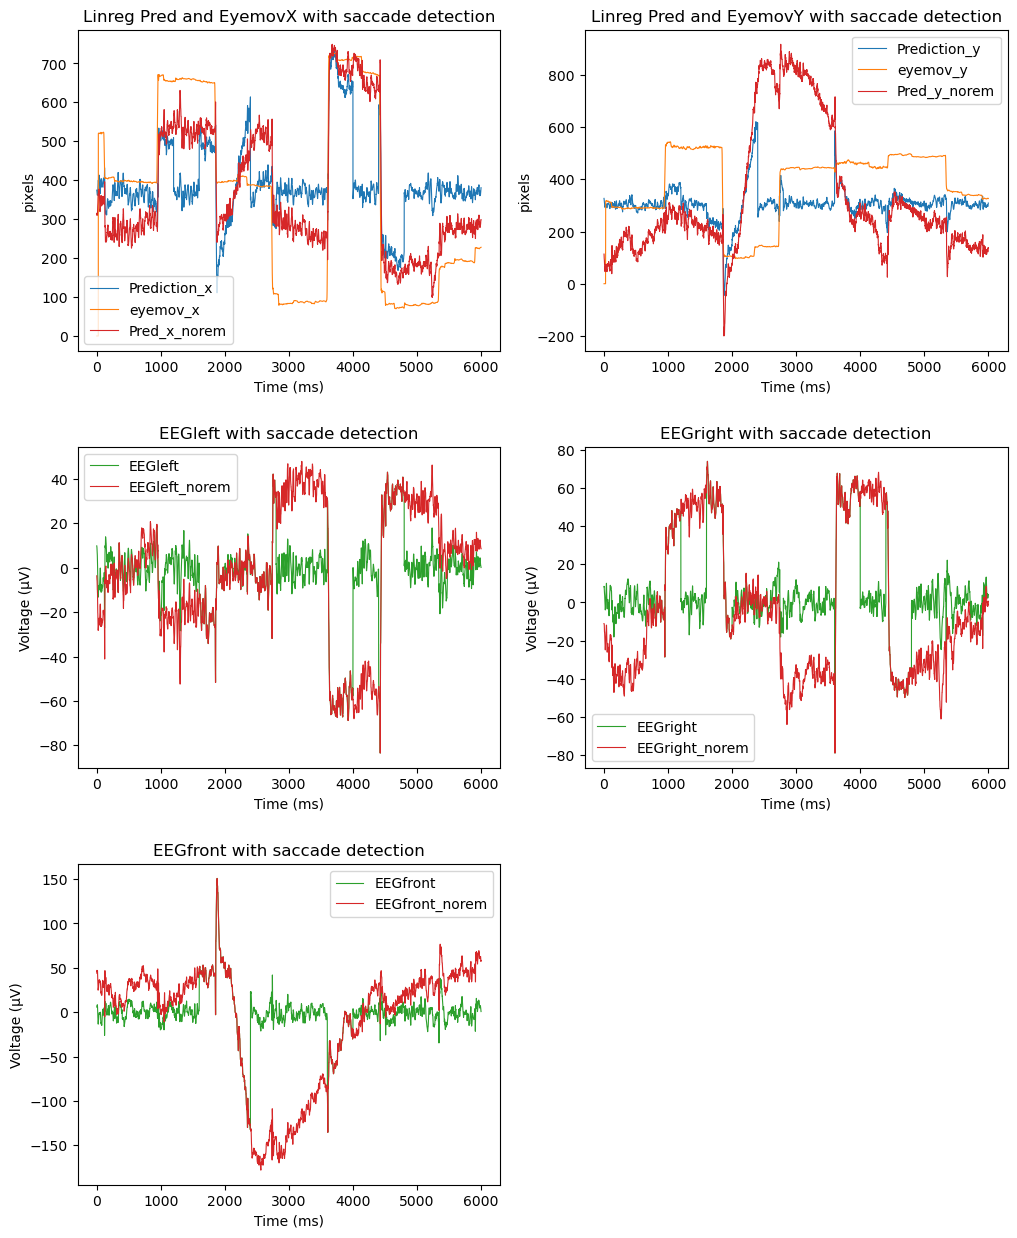

In [16]:
min_t = 0000
max_t = 6000

plt.rcParams['figure.figsize'] = [12, 15]
plt.rc('lines', linewidth=.8)
plt.subplots_adjust(hspace=.3)

plt.subplot(3, 2, 1)
plt.plot(range(min_t,max_t), predx_exp[min_t:max_t], label='Prediction_x')
plt.plot(range(min_t,max_t), labels_xtest[min_t:max_t], label='eyemov_x')
plt.plot(range(min_t,max_t), predx_norem[min_t:max_t], label='Pred_x_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovX with saccade detection")

plt.subplot(3, 2, 2)
plt.plot(range(min_t,max_t), predy_exp[min_t:max_t], label='Prediction_y')
plt.plot(range(min_t,max_t), labels_ytest[min_t:max_t], label='eyemov_y')
plt.plot(range(min_t,max_t), predy_norem[min_t:max_t], label='Pred_y_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.title("Linreg Pred and EyemovY with saccade detection")

plt.subplot(3, 2, 3)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,0], label='EEGleft', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,0], label='EEGleft_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGleft with saccade detection")

plt.subplot(3, 2, 4)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,1], label='EEGright', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,1], label='EEGright_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGright with saccade detection")

plt.subplot(3, 2, 5)
plt.plot(range(min_t,max_t), EEGtest_ts[min_t:max_t,2], label='EEGfront', color='tab:green')
plt.plot(range(min_t,max_t), EEGtest_norem[min_t:max_t,2], label='EEGfront_norem', color='tab:red')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("EEGfront with saccade detection")

In [14]:
# Calculate MSE

MSE_y_norem = mean_squared_error(labels_ytest, predy_norem)
MSE_x_norem = mean_squared_error(labels_xtest, predx_norem)

print("MSE_y_norem: ", MSE_y_norem)
print("MSE_x_norem: ", MSE_x_norem)

MSE_y = mean_squared_error(labels_ytest, predy)
MSE_x = mean_squared_error(labels_xtest, predx)

print("MSE_y: ", MSE_y)
print("MSE_x: ", MSE_x)



MSE_y_exp = mean_squared_error(labels_ytest, predy_exp)
MSE_x_exp = mean_squared_error(labels_xtest, predx_exp)

print("MSE_y_exp: ", MSE_y_exp)
print("MSE_x_exp: ", MSE_x_exp)


MSE_y_norem:  31144.46285110553
MSE_x_norem:  16567.62271709905
MSE_y:  26624.641515336247
MSE_x:  42622.412126356314
MSE_y_exp:  25540.27306958382
MSE_x_exp:  33806.05108975982


## Code for Plot Generation for Paper

### Eye movement plot, Fig 1.1

Text(0.5, 1.0, 'Eye movement x Patient 22')

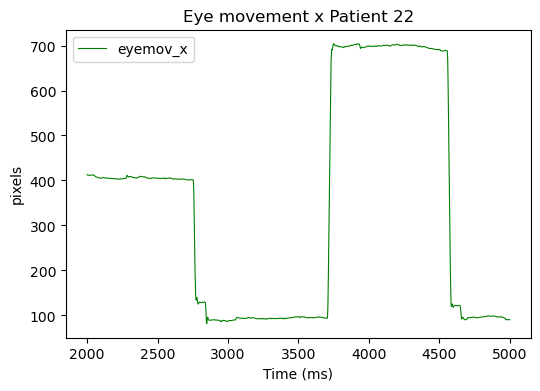

In [29]:
a = 2000
b = 5000
plt.rcParams["figure.figsize"] = (6,4)

plt.plot(range(labels_x.shape[0])[a:b], labels_x[a:b], label='eyemov_x', color='green')

plt.xlabel("Time (ms)")
plt.ylabel("pixels")
plt.legend()
plt.title("Eye movement x Patient 22")

### Kalman Filtering, fig 2.1

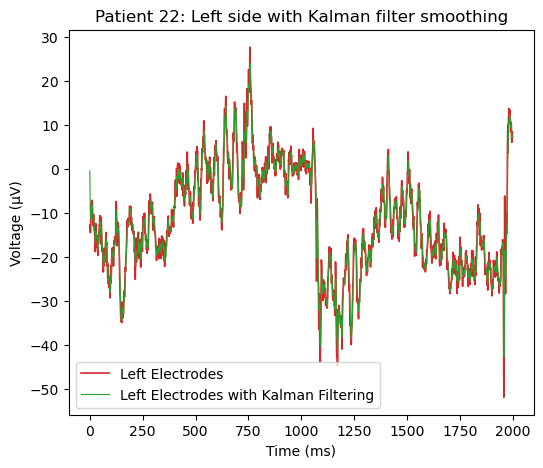

In [22]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from filterpy.common import Saver

a = 0
b = 2000

def getLRF_nosmooth(EEGdata):
    # Same as getLRF_ts() but without median filter

    # left side
    Electr_128 = EEGdata['channel_127'].to_numpy()
    Electr_32 = EEGdata['channel_31'].to_numpy()
    Electr_38 = EEGdata['channel_37'].to_numpy()
    EEGleft = (Electr_128 + Electr_32 + Electr_38) / 3
    
    # Right side
    Electr_125 = EEGdata['channel_124'].to_numpy()
    Electr_1 = EEGdata['channel_0'].to_numpy()
    Electr_121 = EEGdata['channel_120'].to_numpy()
    EEGright = (Electr_125 + Electr_1 + Electr_121) / 3

    # front (node 17)
    EEGfront = EEGdata['channel_16'].to_numpy()
    return EEGleft, EEGright, EEGfront

left, right, front = getLRF_nosmooth(EEG)

x = left[a:b]
y = right[a:b]

ground_truth = np.vstack((x, y)).T
np.random.seed(22)
times = range(x.shape[0])
x_pert = x
y_pert = y
observations = np.vstack((x_pert, y_pert)).T

# Code is based on https://nbviewer.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb
def get_kf():
        initial_state_mean = np.array([[ground_truth[0, 0],0,ground_truth[0, 1],0]]).T
        transition_matrix = np.eye(4)
        dt = 17/700
        transition_matrix = np.array([[1,  0, 0,  0],
                                      [0,  1, 0,  0],
                                      [0,  0, 1, dt],
                                      [0,  0, 0,  1]])
        
        observation_matrix = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

        kf1 = KalmanFilter(dim_x=4, dim_z=2)
        kf1.u = 0
        kf1.F = transition_matrix
        q = Q_discrete_white_noise(dim=2, dt=1, var=1)
        kf1.Q = block_diag(q, q)
        kf1.H = observation_matrix
        kf1.R = np.eye(2)
        kf1.x = initial_state_mean
        kf1.P = np.eye(4) * 500
        return kf1


def filter_data(kf, zs):
    s = Saver(kf)
    kf.batch_filter(zs, saver=s)
    s.to_array()
    return s


N = observations.shape[0]
zs = observations
kf = get_kf()
mu, cov, _, _ = kf.batch_filter(zs)
#print(mu)
# print(cov)
for x_, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x_[0, 0], x_[2, 0])
filtered = filter_data(kf, zs)
xfinal = filtered.x[:,0,0]

plt.rcParams["figure.figsize"] = (6,5)
plt.plot(range(a,b), x_pert, label='Left Electrodes', color='tab:red', linewidth=1.2)
plt.plot(range(a,b), xfinal, label='Left Electrodes with Kalman Filtering', color='tab:green', linewidth=.8)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.legend()
plt.title("Patient 22: Left side with Kalman filter smoothing")
plt.legend()
plt.show()

### Daubechies Wavelet Plot, Fig 2.4

Text(0.5, 1.0, 'Wavelet: db9 at level 9')

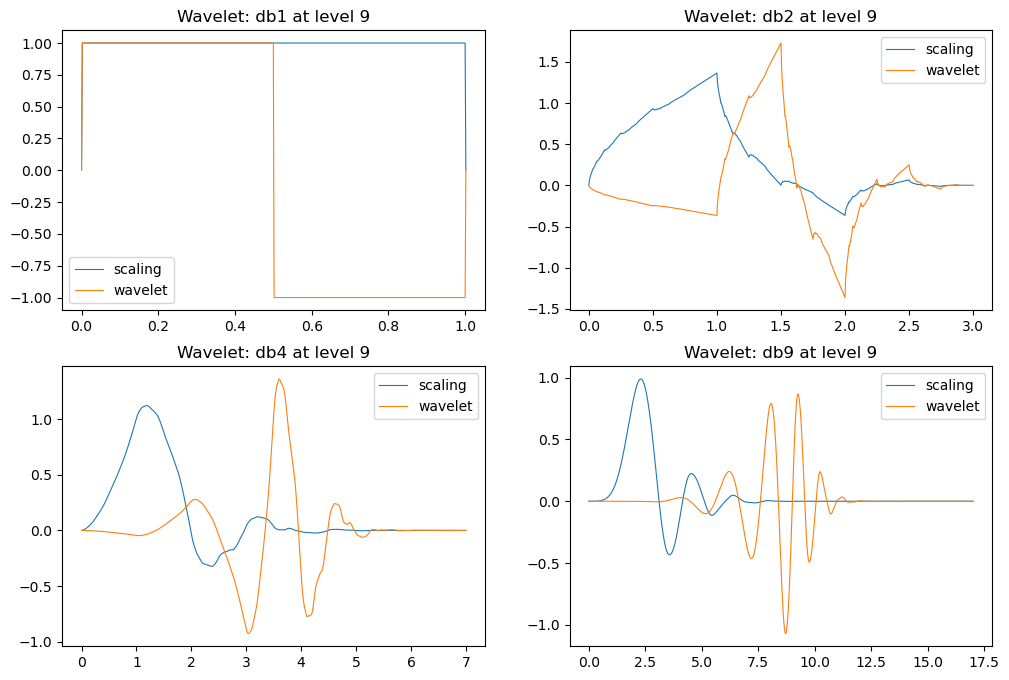

In [23]:
plt.rcParams["figure.figsize"] = (12,8)

plt.subplot(2, 2, 1)
phi, psi, x = pywt.Wavelet('db1').wavefun(level=9)
plt.plot(x, phi, label='scaling')
plt.plot(x, psi,label='wavelet')
plt.legend()
plt.title('Wavelet: db1 at level 9')

plt.subplot(2, 2, 2)
phi, psi, x = pywt.Wavelet('db2').wavefun(level=9)
plt.plot(x, phi, label='scaling')
plt.plot(x, psi,label='wavelet')
plt.legend()
plt.title('Wavelet: db2 at level 9')

plt.subplot(2, 2, 3)
phi, psi, x = pywt.Wavelet('db4').wavefun(level=9)
plt.plot(x, phi, label='scaling')
plt.plot(x, psi,label='wavelet')
plt.legend()
plt.title('Wavelet: db4 at level 9')

plt.subplot(2, 2, 4)
phi, psi, x = pywt.Wavelet('db9').wavefun(level=9)
plt.plot(x, phi, label='scaling')
plt.plot(x, psi,label='wavelet')
plt.legend()
plt.title('Wavelet: db9 at level 9')

### Left Right Front Averaging, Fig 3.1

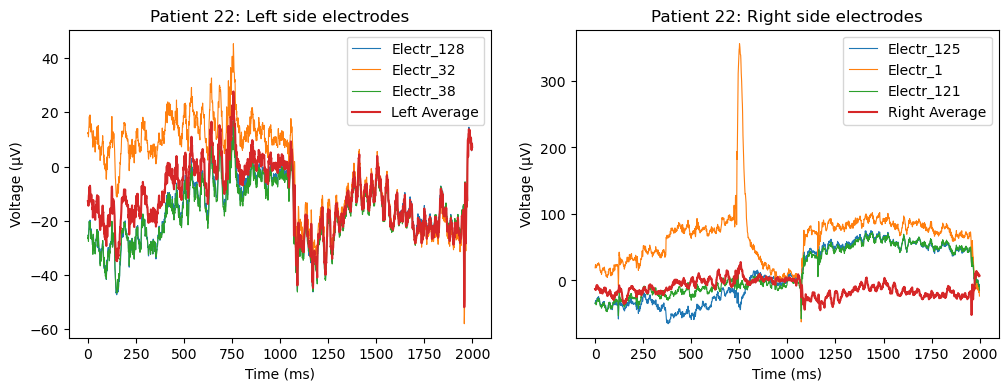

In [25]:
min = 0
max = 2000

plt.rc('lines', linewidth=.8)
plt.rcParams["figure.figsize"] = (12,4)

Electr_128 = EEG['channel_127'].to_numpy()
Electr_32 = EEG['channel_31'].to_numpy()
Electr_38 = EEG['channel_37'].to_numpy()
EEGleft = (Electr_128 + Electr_32 + Electr_38) / 3

Electr_125 = EEG['channel_124'].to_numpy()
Electr_1 = EEG['channel_0'].to_numpy()
Electr_121 = EEG['channel_120'].to_numpy()
EEGright = (Electr_125 + Electr_1 + Electr_121) / 3

plt.subplot(1, 2, 1)
plt.plot(range(min, max), Electr_128[min:max], label='Electr_128')
plt.plot(range(min, max), Electr_32[min:max], label='Electr_32')
plt.plot(range(min, max), Electr_38[min:max], label='Electr_38')
plt.plot(range(min, max), EEGleft[min:max], label='Left Average', linewidth=1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Left side electrodes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(min, max), Electr_125[min:max], label='Electr_125')
plt.plot(range(min, max), Electr_1[min:max], label='Electr_1')
plt.plot(range(min, max), Electr_121[min:max], label='Electr_121')
plt.plot(range(min, max), EEGleft[min:max], label='Right Average', linewidth=1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Right side electrodes")
plt.legend()

### Median filtering, Fig 3.2

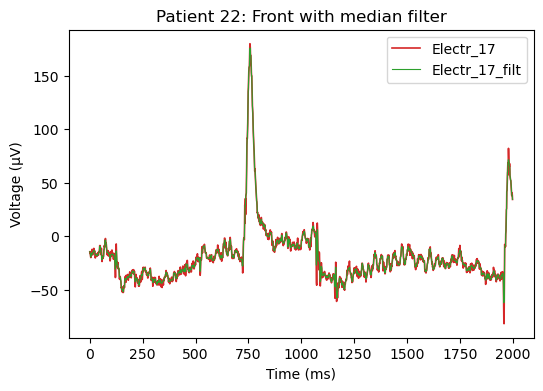

In [26]:
plt.rcParams["figure.figsize"] = (6,4)
EEGfront = EEG['channel_16'].to_numpy()
min = 0
max = 2000

plt.plot(range(min, max), EEGfront[min:max], label='Electr_17', color='tab:red', linewidth=1.2)
plt.plot(range(min, max), medfilt(EEGfront, 5)[min:max], label='Electr_17_filt', color='tab:green')
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.legend()
plt.title("Patient 22: Front with median filter")
plt.show()

### Coarse Coefficient Removal, Fig 3.3

Text(0.5, 1.0, 'Patient 22: Front with cA coeff removed, db9')

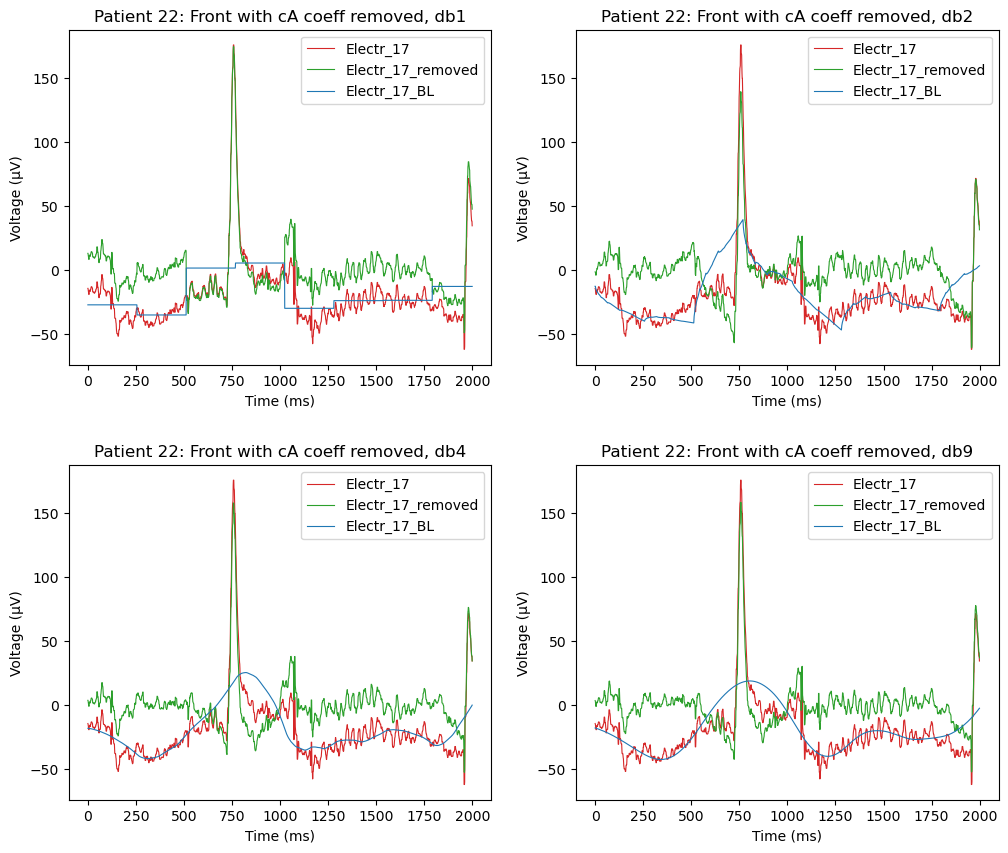

In [27]:
plt.rcParams["figure.figsize"] = (12,10)
plt.subplots_adjust(hspace=.3)
plt.subplot(2, 2, 1)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db1', toremove=[0])
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cA coeff removed, db1")

# repeat above for db2, db4, db9
plt.subplot(2, 2, 2)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db2', toremove=[0])
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cA coeff removed, db2")

plt.subplot(2, 2, 3)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db4', toremove=[0])
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cA coeff removed, db4")

plt.subplot(2, 2, 4)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db9', toremove=[0])
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cA coeff removed, db9")

### Detail Coefficient Removal, Fig 3.4

Text(0.5, 1.0, 'Patient 22: Front with cD7. cD8 coeff removed, db9')

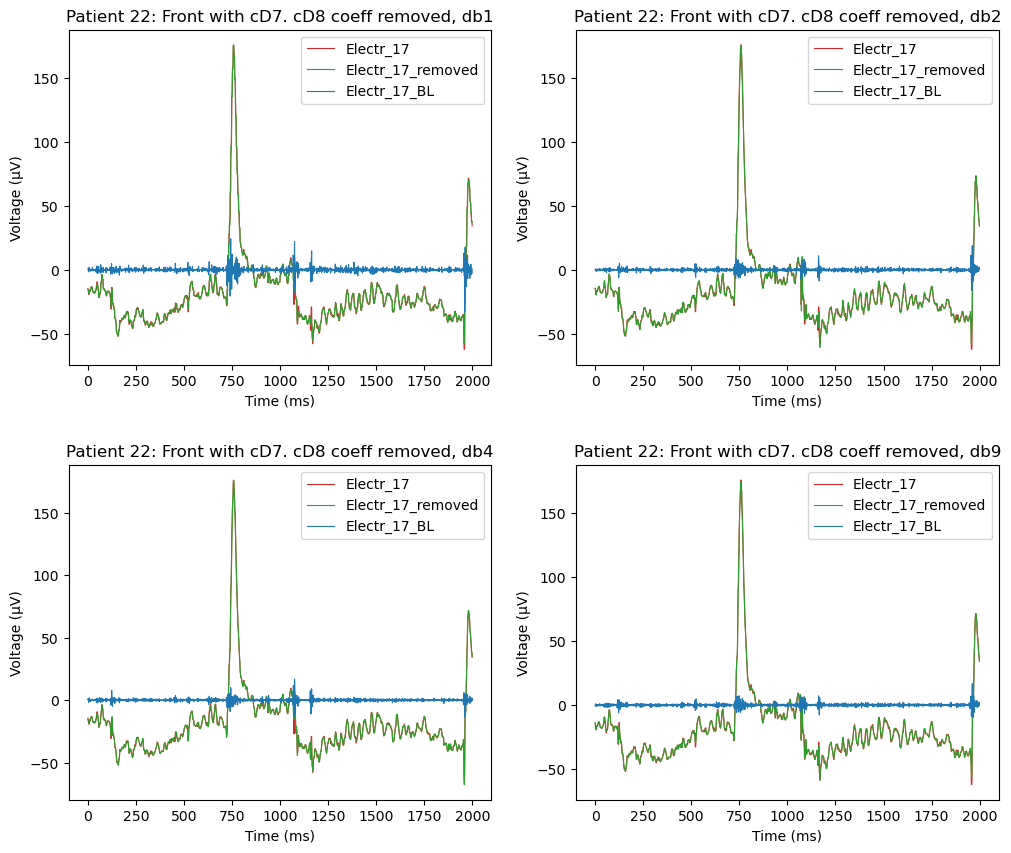

In [30]:
plt.rcParams["figure.figsize"] = (12,10)

TR = [7, 8]
plt.subplots_adjust(hspace=.3)
plt.subplot(2, 2, 1)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db1', toremove=TR)
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cD7. cD8 coeff removed, db1")

# repeat above for db2, db4, db9
plt.subplot(2, 2, 2)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db2', toremove=TR)
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cD7. cD8 coeff removed, db2")

plt.subplot(2, 2, 3)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db4', toremove=TR)
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cD7. cD8 coeff removed, db4")

plt.subplot(2, 2, 4)
EEGfront_rem, EEGfront_BL = remBaseline(medfilt(EEGfront, 5), wv_type='db9', toremove=TR)
plt.plot(range(min, max), medfilt(EEGfront[min:max], 5), label='Electr_17', color='tab:red')
plt.plot(range(min, max), EEGfront_rem[min:max], label='Electr_17_removed', color='tab:green')
plt.plot(range(min, max), EEGfront_BL[min:max], label='Electr_17_BL', color='tab:blue')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.title("Patient 22: Front with cD7. cD8 coeff removed, db9")